In [3]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)


In [4]:
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data()

# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype(
    "category"
)  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(
    ["time_idx", "sku"], observed=True
).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(
    ["time_idx", "agency"], observed=True
).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = (
    data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
)
data.sample(10, random_state=521)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
291,Agency_25,SKU_03,0.5076,2013-01-01,492612703,718394219,25.845238,1264.162234,1152.473405,111.688829,...,-,-,-,8.835008,228,0,1,-0.678062,1225.306376,99.650400
871,Agency_29,SKU_02,8.7480,2015-01-01,498567142,762225057,27.584615,1316.098485,1296.804924,19.293561,...,-,-,-,1.465966,177,24,1,2.168825,1634.434615,11.397086
19532,Agency_47,SKU_01,4.9680,2013-09-01,454252482,789624076,30.665957,1269.250000,1266.490490,2.759510,...,-,-,-,0.217413,322,8,9,1.603017,2625.472644,48.295650
2089,Agency_53,SKU_07,21.6825,2013-10-01,480693900,791658684,29.197727,1193.842373,1128.124395,65.717978,...,-,beer_capital,-,5.504745,240,9,10,3.076505,38.529107,2511.035175
9755,Agency_17,SKU_02,960.5520,2015-03-01,515468092,871204688,23.608120,1338.334248,1232.128069,106.206179,...,-,-,music_fest,7.935699,259,26,3,6.867508,2143.677462,396.022140
7561,Agency_05,SKU_03,1184.6535,2014-02-01,425528909,734443953,28.668254,1369.556376,1161.135214,208.421162,...,-,-,-,15.218151,21,13,2,7.077206,1566.643589,1881.866367
19204,Agency_11,SKU_05,5.5593,2017-08-01,623319783,1049868815,31.915385,1922.486644,1651.307674,271.178970,...,-,-,-,14.105636,17,55,8,1.715472,1385.225478,109.699200
8781,Agency_48,SKU_04,4275.1605,2013-03-01,509281531,892192092,26.767857,1761.258209,1546.059670,215.198539,...,-,-,music_fest,12.218455,151,2,3,8.360577,1757.950603,1925.272108
2540,Agency_07,SKU_21,0.0000,2015-10-01,544203593,761469815,28.987755,0.000000,0.000000,0.000000,...,-,-,-,0.000000,300,33,10,-18.420681,0.000000,2418.719550
12084,Agency_21,SKU_03,46.3608,2017-04-01,589969396,940912941,32.478910,1675.922116,1413.571789,262.350327,...,-,-,-,15.654088,181,51,4,3.836454,2034.293024,109.381800


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21000 entries, 0 to 6650
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   agency                            21000 non-null  category      
 1   sku                               21000 non-null  category      
 2   volume                            21000 non-null  float64       
 3   date                              21000 non-null  datetime64[ms]
 4   industry_volume                   21000 non-null  int64         
 5   soda_volume                       21000 non-null  int64         
 6   avg_max_temp                      21000 non-null  float64       
 7   price_regular                     21000 non-null  float64       
 8   price_actual                      21000 non-null  float64       
 9   discount                          21000 non-null  float64       
 10  avg_population_2017               21000 non-null  in

In [6]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length
    // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={
        "special_days": special_days
    },  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(
    training, data, predict=True, stop_randomization=True
)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)


In [5]:
# pl.seed_everything(42)
# trainer = pl.Trainer(
#     accelerator="gpu",
#     # clipping gradients is a hyperparameter and important to prevent divergance
#     # of the gradient for recurrent neural networks
#     gradient_clip_val=0.1,
# )


# tft = TemporalFusionTransformer.from_dataset(
#     training,
#     # not meaningful for finding the learning rate but otherwise very important
#     learning_rate=0.03,
#     hidden_size=8,  # most important hyperparameter apart from learning rate
#     # number of attention heads. Set to up to 4 for large datasets
#     attention_head_size=1,
#     dropout=0.1,  # between 0.1 and 0.3 are good values
#     hidden_continuous_size=8,  # set to <= hidden_size
#     loss=QuantileLoss(),
#     optimizer="ranger",
#     # reduce learning rate if no improvement in validation loss after x epochs
#     # reduce_on_plateau_patience=1000,
# )
# print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")
# print(pl.__version__)


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\davyx\anaconda3\envs\satcast\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\davyx\anaconda3\envs\satcast\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Number of parameters in network: 13.5k
2.4.0


C:\Users\davyx\anaconda3\envs\satcast\Lib\site-packages\lightning\pytorch\loops\utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
You are using a CUDA device ('NVIDIA GeForce RTX 4090 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\davyx\anaconda3\envs\satcast\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
C:\Users\davyx\anaconda3\envs\satcast\Lib\site-packages\light

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.0097723722095581
Restoring states from the checkpoint path at C:\Users\davyx\桌面\学习\Capstone_SatCast_Trilemma\analysis\.lr_find_24353805-3c6f-46c7-9e94-4805dbad26cb.ckpt
Restored all states from the checkpoint at C:\Users\davyx\桌面\学习\Capstone_SatCast_Trilemma\analysis\.lr_find_24353805-3c6f-46c7-9e94-4805dbad26cb.ckpt


suggested learning rate: 0.0097723722095581


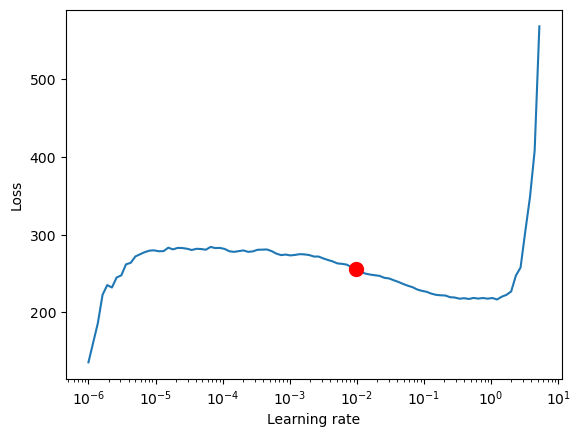

C:\Users\davyx\AppData\Local\Temp\ipykernel_12640\4268711780.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [6]:
# # find optimal learning rate
# from lightning.pytorch.tuner import Tuner

# res = Tuner(trainer).lr_find(
#     tft,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
#     max_lr=10.0,
#     min_lr=1e-6,
# )

# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

In [ ]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [14]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [
        last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i))
        for i in range(1, max_prediction_length + 1)
    ],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = (
    decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
)
decoder_data["time_idx"] += (
    encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()
)

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype(
    "category"
)  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ]
last_data[(last_data["agency"] == "Agency_52") & (last_data["sku"]=="SKU_02")][time_varying_unknown_reals]
decoder_data[(decoder_data["agency"] == "Agency_52") & (decoder_data["sku"]=="SKU_02")]
last_data[(last_data["agency"] == "Agency_52") & (last_data["sku"]=="SKU_02")]
decoder_data[(decoder_data["agency"] == "Agency_52") & (decoder_data["sku"]=="SKU_02")]
decoder_data

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
0,Agency_52,SKU_02,1455.40800,2018-01-01,618073219,919709619,30.759805,1709.140347,1403.137086,306.003261,...,-,-,-,17.903928,47,60,1,7.283042,2267.730115,590.241720
1,Agency_32,SKU_05,3606.51600,2018-01-01,618073219,919709619,22.717406,1924.429706,1559.952757,364.476949,...,-,-,-,18.939478,147,60,1,8.190497,1530.930920,1863.056125
2,Agency_09,SKU_21,0.92655,2018-01-01,618073219,919709619,31.129991,2476.908694,2233.819815,243.088879,...,-,-,-,9.814204,53,60,1,-0.076287,0.354645,2434.174114
3,Agency_08,SKU_04,186.77970,2018-01-01,618073219,919709619,25.373665,2486.862499,1934.749052,552.113447,...,-,-,-,22.201205,335,60,1,5.229930,1408.486009,76.037400
4,Agency_52,SKU_05,963.10050,2018-01-01,618073219,919709619,30.759805,1890.908050,1632.868569,258.039481,...,-,-,-,13.646326,46,60,1,6.870158,1530.930920,590.241720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,Agency_08,SKU_03,9.81360,2018-06-01,618073219,919709619,25.373665,1706.410263,1455.262060,251.148203,...,-,-,-,14.717926,336,65,6,2.283769,2304.827516,76.037400
2096,Agency_60,SKU_05,2235.34950,2018-06-01,618073219,919709619,23.081069,1898.981558,1528.616113,370.365445,...,-,-,-,19.503372,188,65,6,7.712153,1530.930920,3311.367493
2097,Agency_19,SKU_05,87.54300,2018-06-01,618073219,919709619,27.432590,1902.160687,1547.299733,354.860954,...,-,-,-,18.655677,162,65,6,4.472130,1530.930920,56.557950
2098,Agency_60,SKU_03,325.87920,2018-06-01,618073219,919709619,23.081069,1704.503815,1444.443913,260.059902,...,-,-,-,15.257220,187,65,6,5.786527,2304.827516,3311.367493


In [ ]:
new_raw_predictions = tft.predict(
    new_prediction_data,
    mode="raw",
    return_x=True,
    trainer_kwargs=dict(accelerator="gpu"),
)

for idx in range(10):  # plot 10 examples
    tft.plot_prediction(
        new_raw_predictions.x,
        new_raw_predictions.output,
        idx=idx,
        show_future_observed=False,
    )


In [ ]:
decoder_data_try = decoder_data.copy()
decoder_data_try[time_varying_unknown_reals] = 0

new_prediction_data_try = pd.concat([encoder_data, decoder_data_try], ignore_index=True)
new_prediction_data_try

In [ ]:
new_raw_predictions_try = tft.predict(
    new_prediction_data_try,
    mode="raw",
    return_x=True,
    trainer_kwargs=dict(accelerator="gpu"),
)


In [ ]:
assert torch.allclose(new_raw_predictions_try.output.prediction, new_raw_predictions.output.prediction), "Predictions are not equal"

In [ ]:
assert torch.equal(new_raw_predictions_try.output.prediction, new_raw_predictions.output.prediction), "Predictions are not exactly equal"
